In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import uuid
import os

from langchain_core.messages import HumanMessage
from langfuse.langchain import CallbackHandler

from src.ai.assistant import build_graph

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
async def visualize_assistant_graph():
    graph = await build_graph()
    return graph

In [6]:
assistant_graph = await visualize_assistant_graph()
print(assistant_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	conversation(conversation)
	vector_db_node(vector_db_node)
	synthesizer(synthesizer)
	__end__([<p>__end__</p>]):::last
	__start__ --> conversation;
	conversation --> vector_db_node;
	vector_db_node --> synthesizer;
	synthesizer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



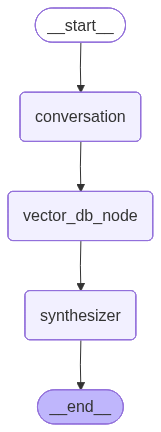

In [7]:
assistant_graph

In [8]:
from typing import AsyncIterator, AsyncGenerator

async def ai_response_generator(stream: AsyncIterator) -> AsyncGenerator[str, None]:
    async for message_chunk, metadata in stream:
        if metadata['langgraph_node'] == 'synthesizer':
            yield message_chunk.content


async def patched_ai_response_generator(stream: AsyncIterator) -> AsyncGenerator[str, None]:
    gen = ai_response_generator(stream)

    try:
        first_chunk = await gen.__anext__()
        yield "AI: " + first_chunk
    except StopAsyncIteration:
        return

    async for chunk in gen:
        yield chunk

In [9]:
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

In [10]:
thread_id = str(uuid.uuid4())

config = {"configurable": {"thread_id" : thread_id}, "callbacks": [langfuse_handler]}

In [11]:
while True:
    user_message = input("\nUser: ")

    if user_message.strip() == '/bye':
        print("Exiting chat. Goodbye!")
        break

    graph_steps_stream = assistant_graph.astream(
        {"messages": [HumanMessage(content=user_message)]}, 
        config=config, 
        stream_mode="messages"
    )

    # Create the generator by calling the function
    response_gen = patched_ai_response_generator(graph_steps_stream)
    
    async for chunk in response_gen:
        print(chunk, end='', flush=True)
    
    print()  # Add newline after response


User:  Who suggested Lincoln grow a beard?


2025-11-05 08:25:01,088 - gpt-oss-vllm-rag - INFO - Loading collection=`wiki-v1` from ChromaDB
2025-11-05 08:25:01,098 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


AI: Lincoln first grew a beard in 1860 after the suggestion of an 11‑year‑old girl named **Grace Bedell**.



User:  /bye


Exiting chat. Goodbye!


In [ ]:
# https://huggingface.co/datasets/rag-datasets/rag-mini-wikipedia